### Fitness4All Business Location Prospecting Project

### Introduction/Business Problem 

Fitness4All operates several gyms in the state of New Jersey. The company is looking to expand into Pennsylvania and would like to identify a shortlist of locations (Townships) with the best prospects for profitability. Fitness4All is a family-owned business offering a good range of fitness equipment in bright, comfortable surroundings and opportunities for clients to work with staff on personalized training plans to meet their goals. It does not compete with upscale facilities marketed to young professionals in major urban centers and commuter towns and its fees are correspondingly lower. For new business opportunities, it looks for Townships of between 20K and 50K population, which are often under-served by major national and regional chains. 

### Data 

This project will use readily available population data from Wikipedia to identify a baseline list of possible PA townships and their populations (https://en.wikipedia.org/wiki/List_of_populated_places_in_Pennsylvania).

It will use US census data to identify key demographics for each county in NJ and PA (this seems not be readily available at a Township level). We use the City and County Data Book: 2007 for demographic data , which is available at online at https://www.census.gov/library/publications/2010/compendia/databooks/ccdb07.html. Because this data seems to be only available in .pdf format, it was scraped to an Excelworksheet and stored locally. The US government no longer publishes this information (since 2012) and the 2007 data was the most recent I could find online.

We will use Foursquare location data to explore existing locations for gym facilities in short-listed township e.g. to discover competitor facilities and complimentary amenities. The following link was also used to retrieve square mileage information for each PA township https://www.indexmundi.com/facts/united-states/quick-facts/pennsylvania/land-area/cities#table. 

### Methodology

The methodology for this project is as follows:<br/>

I. Identify PA Townships with a population of 20,000 - 50,000 and plot the prospective Townships on a Folium map to review the distribution of potential locations<br/>
II. Perform a clustering analysis to compare NJ and PA counties based on demographics. This will enable us to identify counties in PA which are most like NJ counties where Fitness4All NJ locations have been successful<br/>
III. Perform Foursquare venue searches to identify competities gym facilities and complimentary amenities existing in focus Townships (using coffee shops as a proxy). A Township may be in a county with favorable demographics, but too many competitors per unit of population will make it unattractive<br/>
IV. Use the information from III. & IV. to select the final shortlist Townships for further analysis and on-the-ground visits.

In [1]:
# import key libraries
import requests # library to handle requests
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
print('Folium installed')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Folium installed


###### I. Identify and review PA Townships with a population of 20,000 - 50,000 (and add square miles information)

In [2]:
# Create a df for towns in PA that meet our filter criteria
df=pd.read_html('https://en.wikipedia.org/wiki/List_of_populated_places_in_Pennsylvania')[0]
population=df[['Place Name','Population (2010 census)']]
population.columns=['Town','Population']
towns=population.query('Population>20000 & Population<50000')
towns.reset_index(inplace=True,drop=True)
towns.head()

,Town,Population
0,Harrisburg,49528
1,Altoona,46320
2,York,43718
3,State College,42034
4,Wilkes-Barre,41498


In [3]:
towns.tail()

,Town,Population
17,Allison Park,21552
18,Johnstown,20978
19,West Mifflin,20313
20,Chambersburg,20268
21,Murrysville,20079


In [4]:
# Retrieve square mileage information
square_miles=pd.read_html('https://www.indexmundi.com/facts/united-states/quick-facts/pennsylvania/land-area/cities#table')[1]
square_miles.columns=['Town','Sq_Miles']
#square_miles['Radius']=square_miles.apply(lambda row: ((row.Sq_Miles)/3.14)**(0.5),axis=1)
square_miles.head()

# Note: I had initially thought square mileage information would be needed to calibrate
# the Foursquare serch radius for Townships of different sizes. This turned out to not be
# a particularly valuable step: Foursquare automatically searches within defined boundaries for
# a named Township, County etc. when no radius is specified

,Town,Sq_Miles
0,Aliquippa,4.19
1,Allentown,17.55
2,Allison Park,13.84
3,Altoona,9.91
4,Ambler,0.85


In [5]:
# Add square miles information
towns = pd.merge(towns,square_miles,on='Town',how='left')
towns.head() #note: square-miles is not available for Wilkes-Barre

,Town,Population,Sq_Miles
0,Harrisburg,49528,8.13
1,Altoona,46320,9.91
2,York,43718,5.29
3,State College,42034,4.56
4,Wilkes-Barre,41498,NaN


In [6]:
# create column with extended address for co-ordinates search 
state="PA"
towns['State']=state
towns["Full_address"]=towns['Town'].str.cat(towns['State'],sep = ", ")
towns.head()

,Town,Population,Sq_Miles,State,Full_address
0,Harrisburg,49528,8.13,PA,"Harrisburg, PA"
1,Altoona,46320,9.91,PA,"Altoona, PA"
2,York,43718,5.29,PA,"York, PA"
3,State College,42034,4.56,PA,"State College, PA"
4,Wilkes-Barre,41498,NaN,PA,"Wilkes-Barre, PA"


In [7]:
towns.shape

(22, 5)

In [8]:
# find co-ordinates for towns
coordinates=pd.DataFrame(columns=['Full_address','Latitude','Longitude'])

address=towns['Full_address']
for i in address:
    geolocator = Nominatim(user_agent="banana")
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude 
    coordinates = coordinates.append({'Full_address': i,
                                       'Latitude': latitude,
                                        'Longitude':longitude},ignore_index=True)
coordinates.head()

,Full_address,Latitude,Longitude
0,"Harrisburg, PA",40.266311,-76.886112
1,"Altoona, PA",40.518681,-78.394736
2,"York, PA",39.906750,-76.700895
3,"State College, PA",40.794450,-77.861639
4,"Wilkes-Barre, PA",41.246482,-75.881732


In [9]:
# merge co-ordinates information into main towns df
towns = pd.merge(towns,coordinates,on='Full_address',how='left')
towns.head()

,Town,Population,Sq_Miles,State,Full_address,Latitude,Longitude
0,Harrisburg,49528,8.13,PA,"Harrisburg, PA",40.266311,-76.886112
1,Altoona,46320,9.91,PA,"Altoona, PA",40.518681,-78.394736
2,York,43718,5.29,PA,"York, PA",39.906750,-76.700895
3,State College,42034,4.56,PA,"State College, PA",40.794450,-77.861639
4,Wilkes-Barre,41498,NaN,PA,"Wilkes-Barre, PA",41.246482,-75.881732


In [10]:
# check rows as expected
towns.shape

(22, 7)

In [11]:
# find coordinates for the State of PA, to center our map
address = 'Pennsylvania'
geolocator = Nominatim(user_agent="banana")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.9699889 -77.7278831


In [12]:
#display possible locations for a new gym on a map of PA using the 'towns' df
possible_locations = folium.Map(location=[latitude, longitude], zoom_start=7) # generate map centred around the co-ordinates for Pennsylvania

# add the towns as blue circle markers
for lat, lng, label in zip(towns.Latitude, towns.Longitude, towns.Town):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(possible_locations)

# display map
possible_locations

In [13]:
# observing that some Townships are suburbs of Pittsburgh or Philly, which is not our market, use .isin to drop rows for towns in designated list
exclude_list=['Allison Park','Bethel Park','West Mifflin','Monroeville','Plum','Murrysville','Drexel Hill']
towns=towns[~towns['Town'].isin(exclude_list)]
towns.reset_index(inplace=True,drop=True)
towns

,Town,Population,Sq_Miles,State,Full_address,Latitude,Longitude
0,Harrisburg,49528,8.13,PA,"Harrisburg, PA",40.266311,-76.886112
1,Altoona,46320,9.91,PA,"Altoona, PA",40.518681,-78.394736
2,York,43718,5.29,PA,"York, PA",39.906750,-76.700895
3,State College,42034,4.56,PA,"State College, PA",40.794450,-77.861639
4,Wilkes-Barre,41498,NaN,PA,"Wilkes-Barre, PA",41.246482,-75.881732
5,Norristown,34324,3.52,PA,"Norristown, PA",40.121497,-75.339905
6,Chester,33972,4.84,PA,"Chester, PA",39.982931,-75.765242
7,Williamsport,29381,8.73,PA,"Williamsport, PA",41.249329,-77.002767
8,Easton,26800,4.07,PA,"Easton, PA",40.691608,-75.209987
9,Lebanon,25477,4.17,PA,"Lebanon, PA",40.375713,-76.462612


In [14]:
#redraw the revised map of prospective locations
possible_locations = folium.Map(location=[latitude, longitude], zoom_start=7)

# add the towns as blue circle markers
for lat, lng, label in zip(towns.Latitude, towns.Longitude, towns.Town):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(possible_locations)

# display map
possible_locations #shortlist of 15

### II. Perform a clustering analysis to compare NJ and PA counties based on demographics

In [15]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,State,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,...,Persons,HighSchool,Bachelors,ForeignBorn,NonEngLang,SameResidence,SoleCarCommuter,HighIncome,PctPoverty00,PctPoverty04
0,NEW JERSEY,NJ,6.7,13.8,13.0,12.2,16.0,14.9,10.5,6.2,...,5657799,82.1,29.8,17.5,25.5,59.8,73.0,34.9,8.4,7.8
1,Atlantic,NJ,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,...,168546,78.2,18.7,11.8,20.3,57.6,73.1,22.0,10.0,9.5
2,Bergen,NJ,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,...,623469,86.6,38.2,25.1,32.4,62.8,72.8,43.3,5.7,5.0
3,Burlington,NJ,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,...,285553,87.2,28.4,6.3,10.3,60.0,82.7,35.7,5.5,5.1
4,Camden,NJ,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,...,331765,80.3,24.0,6.9,15.6,63.0,74.0,27.1,10.6,10.0


In [16]:
# address column1 header problem
county_demog.rename(columns = {"Unnamed: 0":"County"},inplace=True)
county_demog.head()

,County,State,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,...,Persons,HighSchool,Bachelors,ForeignBorn,NonEngLang,SameResidence,SoleCarCommuter,HighIncome,PctPoverty00,PctPoverty04
0,NEW JERSEY,NJ,6.7,13.8,13.0,12.2,16.0,14.9,10.5,6.2,...,5657799,82.1,29.8,17.5,25.5,59.8,73.0,34.9,8.4,7.8
1,Atlantic,NJ,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,...,168546,78.2,18.7,11.8,20.3,57.6,73.1,22.0,10.0,9.5
2,Bergen,NJ,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,...,623469,86.6,38.2,25.1,32.4,62.8,72.8,43.3,5.7,5.0
3,Burlington,NJ,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,...,285553,87.2,28.4,6.3,10.3,60.0,82.7,35.7,5.5,5.1
4,Camden,NJ,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,...,331765,80.3,24.0,6.9,15.6,63.0,74.0,27.1,10.6,10.0


In [17]:
county_demog.shape

(90, 30)

In [18]:
#use .isin to drop TOTAL rows for NJ and PA
exclude_list=['NEW JERSEY','PENNSYLVANIA']
county_demog=county_demog[~county_demog['County'].isin(exclude_list)]
county_demog.reset_index(inplace=True,drop=True)
county_demog.head()

,County,State,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,...,Persons,HighSchool,Bachelors,ForeignBorn,NonEngLang,SameResidence,SoleCarCommuter,HighIncome,PctPoverty00,PctPoverty04
0,Atlantic,NJ,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,...,168546,78.2,18.7,11.8,20.3,57.6,73.1,22.0,10.0,9.5
1,Bergen,NJ,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,...,623469,86.6,38.2,25.1,32.4,62.8,72.8,43.3,5.7,5.0
2,Burlington,NJ,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,...,285553,87.2,28.4,6.3,10.3,60.0,82.7,35.7,5.5,5.1
3,Camden,NJ,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,...,331765,80.3,24.0,6.9,15.6,63.0,74.0,27.1,10.6,10.0
4,Cape May,NJ,5.0,11.9,12.1,9.8,13.5,15.0,12.2,9.4,...,72878,81.9,22.0,3.2,6.6,61.1,80.1,23.1,8.5,9.3


In [19]:
county_demog.shape

(88, 30)

In [20]:
#drop columns that are deemed redundant or non-material
county_demog.drop(["Persons","ForeignBorn","NonEngLang","SameResidence","PctPoverty00","Native","Pacific"], axis=1,inplace=True)
county_demog.shape

(88, 23)

In [21]:
#create new df of county information for coordinate retrieval (needed for plotting of county clusters)
counties=county_demog[["County","State"]]
counties["Full_address"]=counties['County'].str.cat("County, "+counties['State'],sep = " ")
counties.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,County,State,Full_address
0,Atlantic,NJ,"Atlantic County, NJ"
1,Bergen,NJ,"Bergen County, NJ"
2,Burlington,NJ,"Burlington County, NJ"
3,Camden,NJ,"Camden County, NJ"
4,Cape May,NJ,"Cape May County, NJ"


In [22]:
# find co-ordinates for counties
county_coordinates=pd.DataFrame(columns=['Full_address','Latitude','Longitude'])

address=counties['Full_address']
for i in address:
    geolocator = Nominatim(user_agent="banana")
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude 
    county_coordinates = county_coordinates.append({'Full_address': i,
                                       'Latitude': latitude,
                                        'Longitude':longitude},ignore_index=True)
county_coordinates.head()

,Full_address,Latitude,Longitude
0,"Atlantic County, NJ",39.514327,-74.663288
1,"Bergen County, NJ",40.967835,-74.056325
2,"Burlington County, NJ",39.932541,-74.722667
3,"Camden County, NJ",39.801471,-74.968553
4,"Cape May County, NJ",39.176539,-74.801212


In [23]:
# to prep data for clustering, strip off remaining non-numeric columns and make County the index 
county_demog.drop(["State"], axis=1,inplace=True)
county_demog.describe()
county_demog.set_index('County', inplace=True)

In [24]:
county_demog.shape

(88, 21)

In [25]:
county_demog.head()

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,...,Asian,Hispanic,MalePercentFemales,Households,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04
County,,,,,,,,,,,,,,,,,,,,,
Atlantic,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,6.9,74.0,...,6.3,13.9,94.1,95024,35.7,78.2,18.7,73.1,22.0,9.5
Bergen,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,7.9,79.2,...,13.5,13.3,93.8,330817,34.2,86.6,38.2,72.8,43.3,5.0
Burlington,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,6.4,77.6,...,3.7,5.0,97.8,154371,37.5,87.2,28.4,82.7,35.7,5.1
Camden,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,6.4,73.4,...,4.5,11.3,93.8,185744,38.5,80.3,24.0,74.0,27.1,10.0
Cape May,5.0,11.9,12.1,9.8,13.5,15.0,12.2,9.4,11.1,93.3,...,0.8,4.0,92.2,42148,28.6,81.9,22.0,80.1,23.1,9.3


In [26]:
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

In [27]:
#normalize the variables
from sklearn.preprocessing import StandardScaler
X = county_demog.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.04804393, -0.21469576,  0.61511955, ..., -0.77515122,
         0.21501195,  0.09019122],
       [ 0.5981519 , -0.75864664, -0.73814346, ..., -0.82106549,
         2.09388562, -1.41680135],
       [ 0.82309791, -0.21469576,  0.464757  , ...,  0.69410557,
         1.42348938, -1.38331263],
       ...,
       [-0.75152418, -0.64985646, -1.03886858, ...,  1.00020073,
        -0.27896422, -0.27818474],
       [ 0.29822388,  0.00288459, -0.21187451, ...,  0.47983895,
        -0.44656328,  0.09019122],
       [ 0.29822388, -0.43227611,  0.53993828, ...,  0.9389817 ,
        -0.00551313, -1.01493666]])

In [28]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[3 1 3 1 0 0 1 3 1 0 3 1 1 3 1 3 0 3 0 1 0 0 2 0 0 0 3 0 0 1 0 0 0 0 0 3 0
 0 0 0 0 3 3 1 0 3 0 0 0 0 0 0 0 0 0 3 3 0 0 3 3 0 0 0 0 0 1 0 3 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 3 0 3 0 3]


In [29]:
# assign cluster ID to each row
county_demog["Clus_km"] = labels
county_demog.head(5)

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,...,Hispanic,MalePercentFemales,Households,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04,Clus_km
County,,,,,,,,,,,,,,,,,,,,,
Atlantic,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,6.9,74.0,...,13.9,94.1,95024,35.7,78.2,18.7,73.1,22.0,9.5,3
Bergen,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,7.9,79.2,...,13.3,93.8,330817,34.2,86.6,38.2,72.8,43.3,5.0,1
Burlington,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,6.4,77.6,...,5.0,97.8,154371,37.5,87.2,28.4,82.7,35.7,5.1,3
Camden,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,6.4,73.4,...,11.3,93.8,185744,38.5,80.3,24.0,74.0,27.1,10.0,1
Cape May,5.0,11.9,12.1,9.8,13.5,15.0,12.2,9.4,11.1,93.3,...,4.0,92.2,42148,28.6,81.9,22.0,80.1,23.1,9.3,0


In [30]:
# assign cluster ID to each row in coordinates
county_coordinates["Clus_km"] = labels
county_coordinates.head(5)

,Full_address,Latitude,Longitude,Clus_km
0,"Atlantic County, NJ",39.514327,-74.663288,3
1,"Bergen County, NJ",40.967835,-74.056325,1
2,"Burlington County, NJ",39.932541,-74.722667,3
3,"Camden County, NJ",39.801471,-74.968553,1
4,"Cape May County, NJ",39.176539,-74.801212,0


In [31]:
# additional Matplotlib needed for cluster map
import matplotlib.cm as cm
import matplotlib.colors as colors


# re-center plot to cover PA and NJ, on Harrisburg
address = 'Harrisburg,PA'
geolocator = Nominatim(user_agent="banana")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(county_coordinates['Latitude'], county_coordinates['Longitude'], county_coordinates['Full_address'], county_coordinates['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

40.2663107 -76.8861122


In [32]:
# display average value for each cluster
county_demog.groupby('Clus_km').mean()

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,...,Asian,Hispanic,MalePercentFemales,Households,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04
Clus_km,,,,,,,,,,,,,,,,,,,,,
0,5.230909,12.074545,13.940000,11.670909,14.081818,15.214545,11.554545,7.547273,8.669091,95.52,...,0.669091,2.236364,98.545455,29157.327273,32.796364,80.434545,15.327273,79.283636,14.367273,10.058182
1,6.572727,13.590909,12.918182,12.090909,15.736364,14.918182,10.500000,6.263636,7.363636,77.30,...,6.781818,13.136364,94.518182,238051.181818,35.827273,82.836364,30.045455,72.090909,33.536364,7.654545
2,6.500000,12.650000,14.100000,12.300000,14.100000,14.750000,10.500000,6.550000,8.550000,65.50,...,3.650000,5.600000,88.900000,563610.500000,30.800000,78.750000,23.100000,60.650000,16.550000,13.800000
3,6.055000,13.065000,13.395000,11.865000,15.085000,15.350000,11.005000,6.550000,7.645000,87.63,...,3.160000,7.645000,95.080000,124610.550000,34.515000,82.880000,25.330000,80.180000,26.465000,7.365000


In [33]:
# to repeat clustering taking Township size out of the equation, take a copy of county_demog and drop size-related attributes
county_demog_exsize=county_demog
county_demog_exsize.head()

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,...,Hispanic,MalePercentFemales,Households,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04,Clus_km
County,,,,,,,,,,,,,,,,,,,,,
Atlantic,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,6.9,74.0,...,13.9,94.1,95024,35.7,78.2,18.7,73.1,22.0,9.5,3
Bergen,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,7.9,79.2,...,13.3,93.8,330817,34.2,86.6,38.2,72.8,43.3,5.0,1
Burlington,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,6.4,77.6,...,5.0,97.8,154371,37.5,87.2,28.4,82.7,35.7,5.1,3
Camden,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,6.4,73.4,...,11.3,93.8,185744,38.5,80.3,24.0,74.0,27.1,10.0,1
Cape May,5.0,11.9,12.1,9.8,13.5,15.0,12.2,9.4,11.1,93.3,...,4.0,92.2,42148,28.6,81.9,22.0,80.1,23.1,9.3,0


In [34]:
#drop columns
county_demog_exsize.drop(["Households"],axis=1,inplace=True)

In [35]:
county_demog_exsize.head()

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,...,Asian,Hispanic,MalePercentFemales,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04,Clus_km
County,,,,,,,,,,,,,,,,,,,,,
Atlantic,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,6.9,74.0,...,6.3,13.9,94.1,35.7,78.2,18.7,73.1,22.0,9.5,3
Bergen,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,7.9,79.2,...,13.5,13.3,93.8,34.2,86.6,38.2,72.8,43.3,5.0,1
Burlington,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,6.4,77.6,...,3.7,5.0,97.8,37.5,87.2,28.4,82.7,35.7,5.1,3
Camden,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,6.4,73.4,...,4.5,11.3,93.8,38.5,80.3,24.0,74.0,27.1,10.0,1
Cape May,5.0,11.9,12.1,9.8,13.5,15.0,12.2,9.4,11.1,93.3,...,0.8,4.0,92.2,28.6,81.9,22.0,80.1,23.1,9.3,0


In [36]:
#normalize the variables
from sklearn.preprocessing import StandardScaler
X = county_demog_exsize.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.04804393, -0.21469576,  0.61511955, ...,  0.21501195,
         0.09019122,  1.73350729],
       [ 0.5981519 , -0.75864664, -0.73814346, ...,  2.09388562,
        -1.41680135,  0.11923595],
       [ 0.82309791, -0.21469576,  0.464757  , ...,  1.42348938,
        -1.38331263,  1.73350729],
       ...,
       [-0.75152418, -0.64985646, -1.03886858, ..., -0.27896422,
        -0.27818474,  1.73350729],
       [ 0.29822388,  0.00288459, -0.21187451, ..., -0.44656328,
         0.09019122, -0.68789972],
       [ 0.29822388, -0.43227611,  0.53993828, ..., -0.00551313,
        -1.01493666,  1.73350729]])

In [37]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 2 2 0 1 0 0 2 0 2 0 2 2 2 1 0 1 2 2 0 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1
 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [38]:
# assign cluster ID to each row
county_demog_exsize["Clus_km"] = labels
county_demog_exsize.head(5)

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,...,Asian,Hispanic,MalePercentFemales,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04,Clus_km
County,,,,,,,,,,,,,,,,,,,,,
Atlantic,6.6,13.9,13.1,12.6,15.7,14.8,9.8,6.5,6.9,74.0,...,6.3,13.9,94.1,35.7,78.2,18.7,73.1,22.0,9.5,0
Bergen,5.8,13.3,11.6,10.8,16.3,15.7,11.7,6.9,7.9,79.2,...,13.5,13.3,93.8,34.2,86.6,38.2,72.8,43.3,5.0,2
Burlington,6.1,13.6,13.1,12.4,16.4,15.1,10.5,6.4,6.4,77.6,...,3.7,5.0,97.8,37.5,87.2,28.4,82.7,35.7,5.1,2
Camden,6.8,14.5,14.1,12.1,15.4,14.8,10.2,5.8,6.4,73.4,...,4.5,11.3,93.8,38.5,80.3,24.0,74.0,27.1,10.0,0
Cape May,5.0,11.9,12.1,9.8,13.5,15.0,12.2,9.4,11.1,93.3,...,0.8,4.0,92.2,28.6,81.9,22.0,80.1,23.1,9.3,1


In [39]:
# assign cluster ID to each row in coordinates
county_coordinates["Clus_km"] = labels
county_coordinates.head(5)

,Full_address,Latitude,Longitude,Clus_km
0,"Atlantic County, NJ",39.514327,-74.663288,0
1,"Bergen County, NJ",40.967835,-74.056325,2
2,"Burlington County, NJ",39.932541,-74.722667,2
3,"Camden County, NJ",39.801471,-74.968553,0
4,"Cape May County, NJ",39.176539,-74.801212,1


In [40]:
# additional Matplotlib needed for cluster map
import matplotlib.cm as cm
import matplotlib.colors as colors


# re-center plot to cover PA and NJ, on Harrisburg
address = 'Harrisburg,PA'
geolocator = Nominatim(user_agent="banana")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(county_coordinates['Latitude'], county_coordinates['Longitude'], county_coordinates['Full_address'], county_coordinates['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

40.2663107 -76.8861122


In [41]:
# display average value for each cluster
county_demog.groupby('Clus_km').mean()

,0-5,5-14,15-24,25-34,35-44,45-54,55-64,65-74,75plus,White,AfricanAmerican,Asian,Hispanic,MalePercentFemales,PctHH_withChildren,HighSchool,Bachelors,SoleCarCommuter,HighIncome,PctPoverty04
Clus_km,,,,,,,,,,,,,,,,,,,,
0,7.110000,13.790000,13.5500,13.290000,15.500000,14.310000,10.040000,5.920000,6.500000,68.890000,23.930000,5.120000,19.040000,94.770000,36.540000,76.210000,23.230000,67.210000,25.380000,11.390000
1,5.260938,12.001562,13.8875,11.693750,13.973437,15.142188,11.504688,7.567187,8.959375,95.414063,3.050000,0.726562,2.329687,97.601563,32.217187,80.600000,15.803125,79.507812,14.023438,9.870312
2,6.164286,13.871429,12.9000,11.107143,16.300000,16.085714,11.100000,6.042857,6.385714,85.150000,7.578571,6.014286,6.578571,96.064286,37.321429,87.835714,34.471429,79.850000,40.728571,4.764286


In [42]:
# to confirm if k=3 is optimal: for each value of k, calculate the sum of squared distances to the nearest cluster centre
sum_of_squared_distances = []
K = range(1,12)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

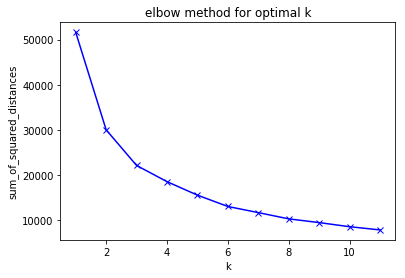

In [43]:
#plot the 'k-elbow'
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show() #suggests diminishing returns after k=3

#### III. Perform Foursquare venue searches to identify competities gym facilities and complimentary amenities existing in focus Townships (using coffee shops as a proxy). A Township may be in a county with favorable demographics, but too many competitors per unit of population will make it unattractive

In [44]:
# firstly, we reduce the list of potential locations based on the clustering analysis
exclude_list=['Norristown','Chester','Pottstown','Harrisburg']
towns=towns[~towns['Town'].isin(exclude_list)]
towns.reset_index(inplace=True,drop=True)
towns #shortlist is now down to 11 towns

,Town,Population,Sq_Miles,State,Full_address,Latitude,Longitude
0,Altoona,46320,9.91,PA,"Altoona, PA",40.518681,-78.394736
1,York,43718,5.29,PA,"York, PA",39.906750,-76.700895
2,State College,42034,4.56,PA,"State College, PA",40.794450,-77.861639
3,Wilkes-Barre,41498,NaN,PA,"Wilkes-Barre, PA",41.246482,-75.881732
4,Williamsport,29381,8.73,PA,"Williamsport, PA",41.249329,-77.002767
5,Easton,26800,4.07,PA,"Easton, PA",40.691608,-75.209987
6,Lebanon,25477,4.17,PA,"Lebanon, PA",40.375713,-76.462612
7,Hazleton,25340,6.01,PA,"Hazleton, PA",40.964687,-75.985279
8,New Castle,23273,8.31,PA,"New Castle, PA",40.999920,-80.347186
9,Johnstown,20978,5.89,PA,"Johnstown, PA",40.326741,-78.921970


In [45]:
# Foursquare credentials 

In [46]:
def getNearbyGymVenues(names, latitudes, longitudes, radius=8000,LIMIT=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    PA_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    PA_venues.columns = ['Town', 
                  'TownLatitude', 
                  'TownLongitude', 
                  'Venue', 
                  'VenueLat', 
                  'VenueLong', 
                  'VenueCat']
    return(PA_venues)


In [47]:
PA_possible_gyms = getNearbyGymVenues(names=towns['Full_address'],latitudes=towns['Latitude'],longitudes=towns['Longitude'])

Altoona, PA
York, PA
State College, PA
Wilkes-Barre, PA
Williamsport, PA
Easton, PA
Lebanon, PA
Hazleton, PA
New Castle, PA
Johnstown, PA
Chambersburg, PA


In [48]:
PA_possible_gyms.head()

,Town,TownLatitude,TownLongitude,Venue,VenueLat,VenueLong,VenueCat
0,"Altoona, PA",40.518681,-78.394736,Texas Hot Dogs,40.516671,-78.401227,Hot Dog Joint
1,"Altoona, PA",40.518681,-78.394736,Tom & Joe's,40.516909,-78.402016,Diner
2,"Altoona, PA",40.518681,-78.394736,Mike's Court,40.525321,-78.402981,Sports Bar
3,"Altoona, PA",40.518681,-78.394736,Railroaders Memorial Museum,40.513852,-78.399393,Museum
4,"Altoona, PA",40.518681,-78.394736,Mama Randazzo's Pizza & Restaurant,40.537989,-78.398165,Italian Restaurant


In [49]:
#eliminate non-gym venues with the str gym in the name or address
myList=['Gym','Gymnastics Gym','Sports Club','College Gym','Gym / Fitness Center']
PA_gyms=pd.DataFrame({'VenueCat':myList}).merge(PA_possible_gyms)
PA_gyms

,VenueCat,Town,TownLatitude,TownLongitude,Venue,VenueLat,VenueLong
0,Gym,"Altoona, PA",40.518681,-78.394736,The Summit Tennis and Athletic Club,40.458013,-78.407453
1,Gym,"York, PA",39.906750,-76.700895,Gold's Gym,39.936469,-76.681822
2,Gym,"York, PA",39.906750,-76.700895,JCC Fitness Center,39.945155,-76.691027
3,Gym,"York, PA",39.906750,-76.700895,York YMCA,39.961010,-76.735408
4,Gym,"Wilkes-Barre, PA",41.246482,-75.881732,VIVE Health & Fitness,41.260391,-75.880278
5,Gym,"Wilkes-Barre, PA",41.246482,-75.881732,Odyssey Fitness,41.236230,-75.866346
6,Gym,"Easton, PA",40.691608,-75.209987,The Fitness Club,40.711767,-75.220654
7,Gym,"Lebanon, PA",40.375713,-76.462612,Arnold Sports Center,40.334626,-76.512999
8,Gym / Fitness Center,"Altoona, PA",40.518681,-78.394736,Planet Fitness,40.485374,-78.402042
9,Gym / Fitness Center,"York, PA",39.906750,-76.700895,Planet Fitness,39.955270,-76.682145


In [50]:
#plot focus towns and associated gym locations - refocus on PA
address = 'Pennsylvania'
geolocator = Nominatim(user_agent="banana")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

#display gym venues on a map of PA
gym_map = folium.Map(location=[latitude, longitude], zoom_start=7) # generate map centred around the co-ordinates for Altoona, PA

# add a red circle marker to represent the centre of each town
for lat, lng, label in zip(towns.Latitude, towns.Longitude, towns.Town):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(gym_map)
    
# add the bars as blue circle markers
for lat, lng, label in zip(PA_gyms.VenueLat, PA_gyms.VenueLong, PA_gyms.Venue):
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        #popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(gym_map)

# display map
gym_map

40.9699889 -77.7278831


#### There seem to be 2 towns with NO gyms nearby (worthy of further investigation!). For the remaining towns, let's look at the number of gyms in relation to Town population

In [51]:
#count gym venues retrieved by town
gym_summary=PA_gyms.groupby('Town').count()
gym_summary

,VenueCat,TownLatitude,TownLongitude,Venue,VenueLat,VenueLong
Town,,,,,,
"Altoona, PA",2,2,2,2,2,2
"Chambersburg, PA",1,1,1,1,1,1
"Easton, PA",2,2,2,2,2,2
"Lebanon, PA",4,4,4,4,4,4
"New Castle, PA",1,1,1,1,1,1
"State College, PA",1,1,1,1,1,1
"Wilkes-Barre, PA",2,2,2,2,2,2
"Williamsport, PA",1,1,1,1,1,1
"York, PA",6,6,6,6,6,6


In [52]:
town_pop=towns[['Full_address','Population']]
town_pop.head()

,Full_address,Population
0,"Altoona, PA",46320
1,"York, PA",43718
2,"State College, PA",42034
3,"Wilkes-Barre, PA",41498
4,"Williamsport, PA",29381


In [53]:
#create df combining number of gyms with population for each focus town
gym_perhead=gym_summary[['Venue']].merge(town_pop,left_on='Town',right_on='Full_address',how='left')

#calculate population per existing gym
gym_perhead['Heads_per_gym']=gym_perhead.apply(lambda row: (row.Population/row.Venue),axis=1).round()
gym_perhead_sorted=gym_perhead.sort_values(by='Heads_per_gym',ascending=False)
gym_perhead_sorted.reset_index(inplace=True)
gym_perhead_sorted

,index,Venue,Full_address,Population,Heads_per_gym
0,5,1,"State College, PA",42034,42034.0
1,7,1,"Williamsport, PA",29381,29381.0
2,4,1,"New Castle, PA",23273,23273.0
3,0,2,"Altoona, PA",46320,23160.0
4,6,2,"Wilkes-Barre, PA",41498,20749.0
5,1,1,"Chambersburg, PA",20268,20268.0
6,2,2,"Easton, PA",26800,13400.0
7,8,6,"York, PA",43718,7286.0
8,3,4,"Lebanon, PA",25477,6369.0


##### V. Use the information from II. & III. to select the final shortlist of Townships and continue with further analysis and on-the-ground visits.<br/>
Having identified 2 Townships without a gym facility and 9 Townships with varying levels of competition, we can use Foursquare for more detailed intelligence on our top prospects e.g. look at possible cross-street locations and their distances from any existing competitors, review locations for complimentary venues such as coffee shops.

In [54]:
address = 'New Castle,PA'
geolocator = Nominatim(user_agent="banana")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.9999202 -80.3471856


In [55]:
search_query='gym,coffee'
radius = 5000
LIMIT=10000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

In [56]:
#code to create a cleaned up df of New Castle gym venues
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
NewCastle_filtered = dataframe.loc[:, filtered_columns]

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

NewCastle_filtered['categories'] = NewCastle_filtered.apply(get_category_type, axis=1)
NewCastle_filtered.columns = [column.split('.')[-1] for column in NewCastle_filtered.columns]
NewCastle_filtered

,name,categories,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Gym,Casino,NaN,US,NaN,United States,809,"[Pennsylvania, United States]","[{'label': 'display', 'lat': 41.004532, 'lng':...",41.004532,-80.339738,NaN,Pennsylvania,4f577668e4b084fcb1f2f4d6
1,Two Rivers Artisan Coffee,Coffee Shop,11 S Mill St,US,New Castle,United States,255,"[11 S Mill St, New Castle, PA 16101, United St...","[{'label': 'display', 'lat': 40.99935292977494...",40.999353,-80.344234,16101,PA,523c700f11d2ce2b487df78f
2,Iron Works Gym,College Gym,NaN,US,New Castle,United States,2049,"[New Castle, PA, United States]","[{'label': 'display', 'lat': 41.007294, 'lng':...",41.007294,-80.324825,NaN,PA,514bab89e4b0cda38e870121
3,Yoki's Italian Cafe,Italian Restaurant,1402 E Washington St,US,New Castle,United States,2440,"[1402 E Washington St, New Castle, PA 16101, U...","[{'label': 'display', 'lat': 40.984926, 'lng':...",40.984926,-80.325989,16101,PA,4e977a979adf6a4ff09cf861
4,Steamers,Café,NaN,US,New Castle,United States,3270,"[New Castle, PA 16105, United States]","[{'label': 'display', 'lat': 41.0284529671706,...",41.028453,-80.337904,16105,PA,4cab636814c33704f03eea3b


In [57]:
#filter out non-gym venues with the str gym in the name or address, and some venues that aren't really coffee shops
myList=['Gym','Gymnastics Gym','Sports Club','College Gym','Gym / Fitness Center','Coffee Shop','Café']

NewCastle=pd.DataFrame({'categories':myList}).merge(NewCastle_filtered)
NewCastle

,categories,name,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,College Gym,Iron Works Gym,NaN,US,New Castle,United States,2049,"[New Castle, PA, United States]","[{'label': 'display', 'lat': 41.007294, 'lng':...",41.007294,-80.324825,NaN,PA,514bab89e4b0cda38e870121
1,Coffee Shop,Two Rivers Artisan Coffee,11 S Mill St,US,New Castle,United States,255,"[11 S Mill St, New Castle, PA 16101, United St...","[{'label': 'display', 'lat': 40.99935292977494...",40.999353,-80.344234,16101,PA,523c700f11d2ce2b487df78f
2,Café,Steamers,NaN,US,New Castle,United States,3270,"[New Castle, PA 16105, United States]","[{'label': 'display', 'lat': 41.0284529671706,...",41.028453,-80.337904,16105,PA,4cab636814c33704f03eea3b


In [58]:
# generate map centred around the co-ordinates for New Castle, PA
NC_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# add a red circle marker to represent the centre of New Castle
folium.features.CircleMarker(
    [latitude, longitude],
    radius=2,
    color='red',
    popup='New Castle',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(NC_map)

# add the bars as blue circle markers
for lat, lng, label in zip(NewCastle.lat, NewCastle.lng, NewCastle.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(NC_map)

# display map
NC_map

Ok, so the only existing gym is a ways out of town (and it's a College Gym, not a commercial Gym, so not an attractive location - and possibly not available - for older clients). There's also a coffee shop in the center of town, a good venue for co-location!

### Results

The results of the analysis have been described step by step above, but to summarize:<br/>
* We originally identified 22 Townships in PA with the range of population we were looking for
* By plotting these on a Folium chart we could see right away that some of them were really part of greater Pittsburgh or Philadelphia; as we do not compete in major urban markets, so we were able to reduce our focus list
* We conducting a clustering analysis using demographic data for NJ and PA counties, and discovered intuitive groupings of Townships which helped us further eliminate from consideration some of the locations on our list (where our brand does not line up well with the demographics). This helped us refine our shortlist further
* We then used Foursquare information to retrieve information about existing gyms and other amenities in these locations. This enabled us to calculate a "gym under-served" index i.e. population/existing gym in each Township and rank the list prospective Townships based on the strength of competition 
* Finally, we showed how any one of the short-listed Townships could be further scrutinized using Foursquare data to review the exact location of competitor facilities and complimentary amenities in any given Township


### Discussion 

There were three problems encountered in the course of this analysis,which can be summarized as follows:<br/>
1. Finding high quality, relevant input data at reasonable cost - some federal, state and municipal government agencies do seem to be moving in the direction of greater transparency and putting datasets of interest onto public websites. On the other hand, the 'City and County Data Book' has apparently not been available from the US Census Bureau since 2012, and an equivalent publication being produced privately costs hundreds of dollars (and is a book or .pdf!). There also seems to be a lot of information interesting to historians and social scientists still in paper and microfiche formats.
2. I could only find demographic data at a County level in the time available, so I had to make the assumption that each Township manifested the demographics of the County in which is was located, which is not ideal
3. I had difficulty running the function to extract gym venue information from Foursquare for each of the focus Townships (def getNearbyGymVenues) based on the Foursqare 'search?' query, frequently getting an 'index out of range' error. After many hours looking at the code, I found this could be avoided by severely reducing the LIMIT constraint on the api call urls, but this returned an unrealistically small number of relevant venues. I had more success using the Foursquare 'explore' query with a very large LIMIT value, which returned a more realistic set of gym venues along with all other venue types. This provided the data needed to complete the analysis, but seems inefficient.



### Conclusion 

This project demonstrates that there are several interesting prospects for further business development Central and Western Pennsylvania!